## Saving a Classification Model

This is a minimal example showing how to train a fastai model on Kaggle, and save it to then be used in an app on huggingfaces.

In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# Make sure we've got the latest version of fastai:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.8/234.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 34.2 MB/s eta 0:00:00


In [3]:
# define our search utility function
from duckduckgo_search import DDGS #DuckDuckGo has changed the api so we need to update 
from fastcore.all import *
import time, json
from fastai.vision.all import *
from fastdownload import download_url

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

First we download and clean our data, which is going to be the classic question of 'hot dog or sandwich' (or burger).
For some reason, `resize_images` now fails with `KeyError: FITS` every time I try and run it, so it has been removed. Instead I iterate through and resize each image individually. I'm sure this is slower than whatever they do on the backend, but it's a one-time pass, and I don't have that many pictures.

In [4]:
%%time

categories = 'hot dog', 'sandwich', 'burger'
base_path = Path('food')

for c in categories:
    dest = (base_path/c)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{c} food'))
    time.sleep(5)
    print(f"Done downloading images for {c}")

failed = verify_images(get_image_files(base_path))
failed.map(Path.unlink)
print(f"{len(failed)} failed downloads")

for c in categories:
    dest = Path(base_path/c)
    images = get_image_files(dest)
    print(f"{len(images)} images for {c}")
    for i in images:
        try:
            resize_image(i, dest, src=dest, max_size=400)
        except KeyError as e:
            print(f"KeyError on file: {i}")
            continue

Done downloading images for hot dog
Done downloading images for sandwich
Done downloading images for burger
14 failed downloads
168 images for hot dog
177 images for sandwich
167 images for burger
CPU times: user 3.67 s, sys: 1.37 s, total: 5.04 s
Wall time: 1min 55s


Now we can create our `DataLoaders`:

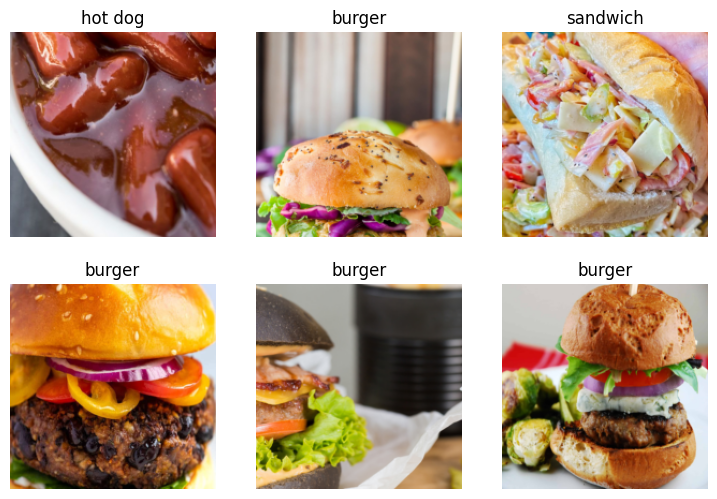

In [5]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[RandomResizedCrop(192, min_scale=0.3)],
).dataloaders(base_path, bs=32)

dls.show_batch(max_n=6)

... and train our model, a resnet18 (to keep it small and fast):

In [6]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 72.3MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.376916,0.358373,0.098039,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.585180,0.219378,0.088235,00:12
1,0.483609,0.182941,0.078431,00:11
2,0.379348,0.148622,0.068627,00:12
3,0.304764,0.132490,0.029412,00:12
4,0.250522,0.068671,0.019608,00:12
5,0.229320,0.067746,0.019608,00:12
6,0.186403,0.075761,0.029412,00:13
7,0.164524,0.070951,0.029412,00:12
8,0.169124,0.073526,0.029412,00:13
9,0.147637,0.071877,0.029412,00:12


Before we export our learner, let's clean the data. (I'm combining a few different notebooks here.) First we plot the confusion matrix, then we look at the top losses and remove them from our training set.

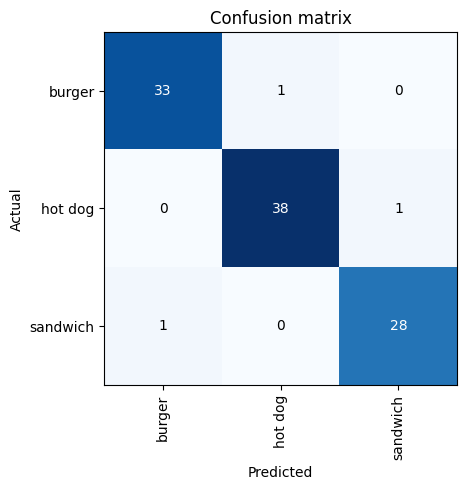

In [7]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

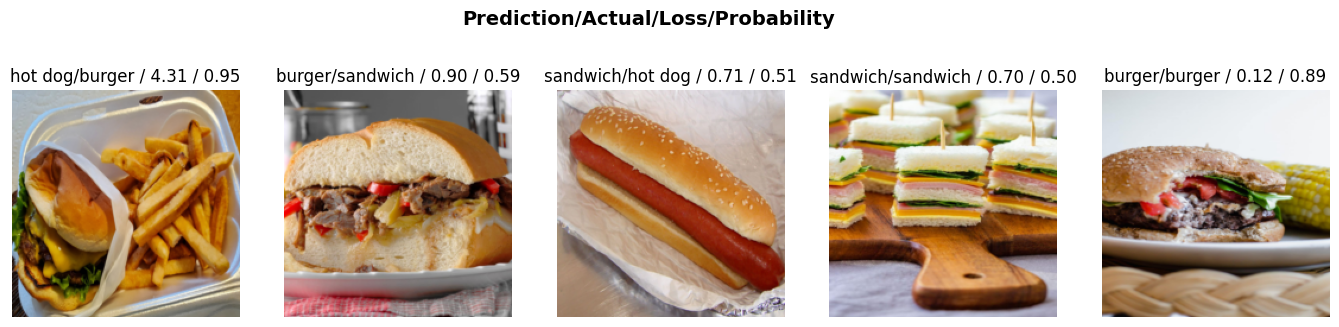

In [8]:
interp.plot_top_losses(5, nrows=1, figsize=(17,4))

In [9]:
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

In [10]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), base_path/cat)

In [11]:
learn.export('model.pkl')

Finally, open the Kaggle sidebar on the right if it's not already, and find the section marked "Output". Open the `/kaggle/working` folder, and you'll see `model.pkl`. Click on it, then click on the menu on the right that appears, and choose "Download". After a few seconds, your model will be downloaded to your computer, where you can then create your app that uses the model.